# 強化学習の基礎

## バンディット問題

In [3]:
#Banditクラスの実装
import numpy as np

class Bandit:
    def __init__(self, arms=10):
        self.rates = np.random.rand(arms)
        
    def play(self, arm):
        rate = self.rates[arm]
        if rate > np.random.rand():
            return 1
        else:
            return 0

In [7]:
#Agentクラスの実装(ε-greedy法による)
class Agent:
    def __init__(self, epsilon, action_size=10):
        self.epsilon = epsilon
        self.Qs = np.zeros(action_size) #スロットの価値の推定値
        self.ns = np.zeros(action_size) #スロットをプレイした回数
        
    def update(self, action, reward):
        self.ns[action] += 1
        self.Qs[action] += (reward - self.Qs[action]) / self.ns[action]
        
    def get_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, len(self.Qs))
        return np.argmax(self.Qs)

760


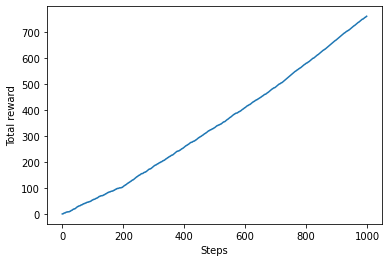

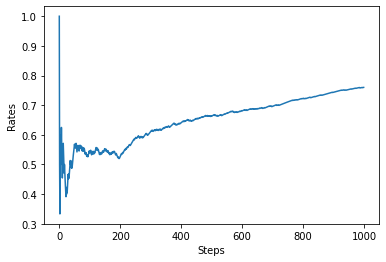

In [9]:
import matplotlib.pyplot as plt

steps = 1000
epsilon = 0.1

bandit = Bandit()
agent = Agent(epsilon)
total_reward = 0
total_rewards = []
rates = []

for step in range(steps):
    action = agent.get_action()
    reward = bandit.play(action)
    agent.update(action, reward)
    total_reward += reward
    
    total_rewards.append(total_reward)
    rates.append(total_reward / (step+1))
    
print(total_reward)

#グラフ描画
plt.ylabel('Total reward')
plt.xlabel('Steps')
plt.plot(total_rewards)
plt.show()

plt.ylabel('Rates')
plt.xlabel('Steps')
plt.plot(rates)
plt.show()

勝率は0.8付近まで上昇しており、正しい学習が行われていることが分かる。また、この手法はランダム性を持った部分が多い（スロットごとの勝率決定や行動選択）ため、実行するごとに結果が異なる。よって、アルゴリズムを評価する際には、複数回行った結果を平均することが多い。

<function matplotlib.pyplot.show(close=None, block=None)>

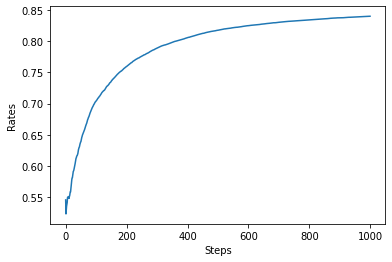

In [10]:
runs = 200
steps = 1000
epsilon = 0.1
all_rates = np.zeros((runs,steps))

for run in range(runs):
    bandit = Bandit()
    agent = Agent(epsilon)
    total_reward = 0
    rates = []

    for step in range(steps):
        action = agent.get_action()
        reward = bandit.play(action)
        agent.update(action,reward)
        total_reward += reward
        rates.append(total_reward / (step + 1))

    all_rates[run] = rates

avg_rates = np.average(all_rates, axis=0)

plt.ylabel('Rates')
plt.xlabel('Steps')
plt.plot(avg_rates)
plt.show

このように、平均した結果を用いることで安定した結果を得ることができる。

## 非定常問題
ここまでのバンディット問題は、報酬の確率分布が定常な問題だったが、ここではそうでない問題を考える。

In [11]:
class NonStatBandit:
    def __init__(self, arms=10):
        self.arms = arms
        self.rates = np.random.rand(arms)

    def play(self, arm):
        rate = self.rates[arm]
        self.rates += 0.1 * np.random.randn(self.arms)
        if rate > np.random.rand():
            return 1
        else:
            return 0

非定常問題においては、データの重要性は古い物ほど低くなる。そのため、古いデータに対する重みは小さくする必要がある。このとき、行動価値の推定値$Q_n$は以下の式で更新される。

$\displaystyle{
Q_n = Q_{n-1} + \alpha(R_n - Q_{n-1})
}$
<br>
このとき、指数関数的に重みが減少することから、この式の計算は**指数移動平均**や**指数加重自動平均**とも呼ばれる。これを実装する。

In [12]:
class AlphaAgent:
    def __init__(self, epsilon, alpha, actions=10):
        self.epsilon = epsilon
        self.Qs = np.zeros(actions)
        self.alpha = alpha

    def update(self, action, reward):
        self.Qs[action] += (reward - self.Qs[action]) * self.alpha

    def get_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, len(self.Qs))
        return np.argmax(self.Qs)

この```AlphaAgent```クラスを用いて```NonStatBandit```クラスをプレイすると以下のようになる。

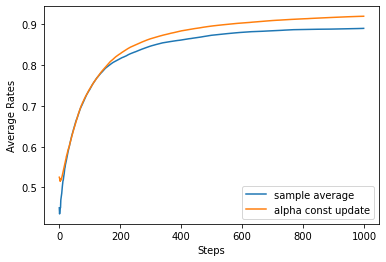

In [13]:
runs = 200
steps = 1000
epsilon = 0.1
alpha = 0.8
agent_types = ['sample average', 'alpha const update']
results = {}

for agent_type in agent_types:
    all_rates = np.zeros((runs, steps))  # (200, 1000)

    for run in range(runs):
        if agent_type == 'sample average':
            agent = Agent(epsilon)
        else:
            agent = AlphaAgent(epsilon, alpha)

        bandit = NonStatBandit()
        total_reward = 0
        rates = []

        for step in range(steps):
            action = agent.get_action()
            reward = bandit.play(action)
            agent.update(action, reward)
            total_reward += reward
            rates.append(total_reward / (step + 1))

        all_rates[run] = rates

    avg_rates = np.average(all_rates, axis=0)
    results[agent_type] = avg_rates

# plot
plt.figure()
plt.ylabel('Average Rates')
plt.xlabel('Steps')
for key, avg_rates in results.items():
    plt.plot(avg_rates, label=key)
plt.legend()
plt.show()

非定常問題に関しては、固定値αを用いて重みを更新した方が良い結果が得られることがわかる。